## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [12]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
# Dictionary to store mtx and dist parameter from all calibration.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
dist_pickle = {} # # Save the camera calibration result for later use.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for index, fname in enumerate(images):
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Do camera calibration given object points and image points
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
        
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        cv2.imwrite('../camera_cal/undist' + str(index) + '.jpg',dst)
        
        # Save the camera calibration result for later use
        dist_pickle["mtx"] = mtx
        dist_pickle["dist"] = dist
        
        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.imshow('dst',dst)
        #cv2.waitKey(500)

cv2.destroyAllWindows()
pickle.dump( dist_pickle, open( "../camera_cal/dist_pickle.p", "wb" ) )

## And so on and so forth...

C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:106: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


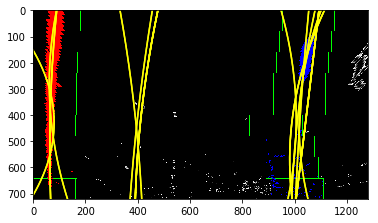

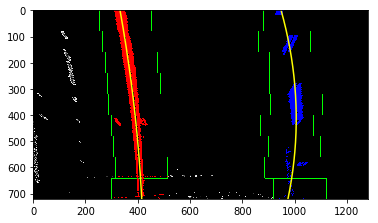

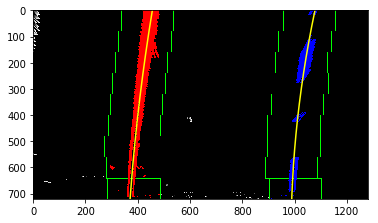

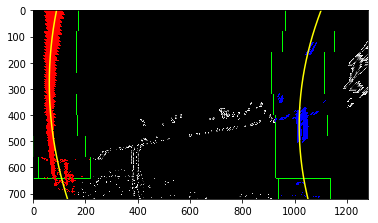

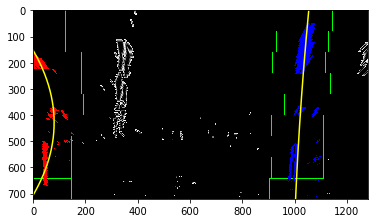

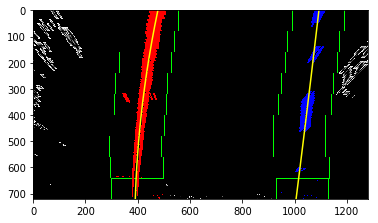

In [28]:
# Undistort driving images by the above result of camera calibration

pickle.load(open("../camera_cal/dist_pickle.p", "rb"))

# Difine the function for binalizing the images.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    #apply threshould
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    #Calculate gradient magnitude
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scal_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    #Apply threshould
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_tjresh[1])] = 1
    return binary_output

def color_threshould(image, sthresh=(0,255), vthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] == 1
    
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] == 1
    
    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary == 1)] == 1
    return output

#def window_mask(width, height, imag_ref, center, level):
#    output = np.zeros_like(img_ref)
#    output[int(img_ref.shape[0])]
#    return output

# Make a list of calibration images
images = glob.glob('../test_images/test*.jpg')

for index, fname in enumerate(images):
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # process image and generate binary pixel of interested
    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient='x', thresh=(12,255)) #12
    grady = abs_sobel_thresh(img, orient='y',  thresh=(25,255)) #25
    c_binary = color_threshould(img, sthresh=(100,255), vthresh=(50,255))
    preprocessImage[((gradx == 1) & (grady == 1) | (c_binary == 1))] = 255
    
    result = preprocessImage
    
    cv2.imwrite('../test_images/tracked' + str(index) + '.jpg',result)
    
    # work on defining perspective transformation area
    #img_size = (img.shape[1], img.shape[0])
    #bot_width = .76 # percent of bottom trapizoid height
    #mid_width = .08 # percent of middle trapizoid height
    #height_pct = .62 # percent for trapizoid height
    #bottom_trim = .935 # percent from top to bottom to avoid car hood
    #src = np.float32([[img.shape[1]*(.5-mid_width/2),img.shape[0]*height_pct],
    #              [img.shape[1]*(.5+mid_width/2),img.shape[0]*height_pct],
    #              [img.shape[1]*(.5-bot_width/2),img.shape[0]*bottom_trim],
    #              [img.shape[1]*(.5+bot_width/2),img.shape[0]*bottom_trim]])
    top_left = (570,470)
    top_right = (720,470)
    bottom_left = (200,720)
    bottom_right = (1130,720)
    top_left_dst = (350,0)
    top_right_dst = (980,0)
    bottom_left_dst = (350,720)
    bottom_right_dst = (980,720)
    src = np.float32([top_left, top_right, bottom_left, bottom_right])
    
    #offset = img_size[0]*.33
    #dst = np.float32([[offset, 0], [img_size[0]-offset, 0], [img_size[0]-offset, img_size[1]], [offset, img_size[1]]])
    dst = np.float32([top_left_dst, top_right_dst, bottom_left_dst, bottom_right_dst])
    
    #perform the transform
    M = cv2.getPerspectiveTransform(src, dst)

    Minv = cv2.getPerspectiveTransform(dst, src)

    binary_warped = cv2.warpPerspective(preprocessImage, M, img_size, flags=cv2.INTER_LINEAR)
       
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    result = binary_warped
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()
    
    cv2.imwrite('../test_images/transform' + str(index) + '.jpg',result)
